In [669]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy

import re
import os

In [670]:
nlp = spacy.load('en_core_web_lg')

In [671]:
df = pd.read_csv('./sample-mcd.csv', encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']]

df['rating'] = df['rating'].apply(lambda x: int(x.split(" ")[0]))

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 3.3+ KB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,5 days ago,Made a mobile order got to the speaker and che...,1
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1


In [672]:
# Load Bing Liu's opinion word dictionary
bing_liu_opinion_words = set()  # Add the actual list of opinion words here

# Function to load opinion words from Bing Liu lexicon
def load_opinion_words(filepath):
    global bing_liu_opinion_words
    temp = pd.read_table(filepath, comment=';', header=None)[0].to_list()
    bing_liu_opinion_words = bing_liu_opinion_words.union(set(temp))


# Load opinion words
current_dir = os.getcwd()
load_opinion_words(os.path.join(current_dir, 'util/opinion-lexicon-English/negative-words.txt'))
load_opinion_words(os.path.join(current_dir, 'util/opinion-lexicon-English/positive-words.txt'))

In [673]:
from contractions import CONTRACTION_MAP

##========== PREPARATION TEXT ===========##

# Contraction
def expand_contractions(sentence, contraction_mapping=CONTRACTION_MAP):
    """
    Expand the contractions in a sentence. For example don't => do not.
    
    Paramters:
    sentence (str): The input sentence to clean.
    contraction_mapping (dict): A dictionary for mapping contractions.
    
    
    Returns:
    str: The expanded contraction sentence.
    """
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    
    def expanded_match(contraction):
        """
        Filter for expanding the matched contraction.
        
        Parameters:
        contraction (str): The input of contraction
        
        Returns:
        str: The expanded contraction.
        """
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())
        
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    
    expanded_sentence = contractions_pattern.sub(expanded_match, sentence)
    return expanded_sentence


def remove_extra_spaces(sentence):
    # Use regex to replace multiple spaces with a single space
    return re.sub(r'\s+', ' ', sentence).strip()


def remove_non_ascii(text):
    """
    Remove all non-ASCII characters from the text.

    Parameters:
    text (str): The input text to clean.

    Returns:
    str: The cleaned text with only ASCII characters.
    
    """
    
    return ''.join([char for char in text if ord(char) < 128])

In [674]:
##=========== EXTRACT ASPECT ============##
# Cross product two lists
def cross_product_str(first, second):
    """
    Do cross product

    parameters
    -----------
    first: list/string
    second: list/string

    return: list of string
    """
    temp = []
    if type(first) == str:
        first = [first]
    if type(second) == str:
        second = [second]
    for i in first:
        for j in second:
            text = (i + ' ' + j).strip()
            temp.append(text)
    return temp

def cross_product_tuple(first, second):
    """
    Do cross product

    parameters
    -----------
    first: list/string
    second: list/string

    return: list of tuple
    """
    temp = []
    if type(first) == str:
        first = [first]
    if type(second) == str:
        second = [second]
    for i in first:
        for j in second:
            temp.append((i, j))
    return temp

# Get neglection text
def get_neglect(token):
    for t in token.children:
        if (t.dep_ == 'neg') or (t.dep_ == 'det' and t.text.lower() == 'no'):
            return 'not'
    return ''

# Get token specific pos tag
def get_token_pos(token, pos):
    if type(pos) == str:
        pos = [pos]
    for t in token.children:
        if t.pos_ in pos:
            return t
    return None

def get_token_pos_left(token, pos):
    if type(pos) == str:
        pos = [pos]
    for t in token.children:
        if (t.pos_ in pos) and (t.i < token.i):
            return t
    return None

def get_token_pos_right(token, pos):
    if type(pos) == str:
        pos = [pos]
    for t in token.children:
        if (t.pos_ in pos) and (t.i > token.i):
            return t
    return None
    
# Get token spcific dependency
def get_token_dep(token, dep):
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep:
            return t
    return None

def get_token_dep_left(token, dep):
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if (t.dep_ in dep) and (t.i < token.i):
            return t
    return None

def get_token_dep_right(token, dep):
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if (t.dep_ in dep) and (t.i > token.i):
            return t
    return None

def get_all_token_dep(token, dep):
    result = []
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep:
            result.append(t)
    return result

def get_all_token_dep_right(token, dep):
    result = []
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep and t.i > token.i:
            result.append(t)
    return result

def get_all_token_dep_left(token, dep):
    result = []
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep and t.i < token.i:
            result.append(t)
    return result

# Get token coordinate conjugation
# def get_token_cc(token):
#     for t in token.children:
#         if t.dep_ == 'cc':
#             return t
#     return None

# Crawling all possibile conjunct
def extract_conj(token, neglect=False, lemma=False):
    result = []
    current = get_token_dep(token, dep='conj')
    while current:
        if neglect:
            neg = get_neglect(current)
            # If lemma
            if lemma:
                text = (neg + ' ' + current.lemma_).strip()
            else:
                text = (neg + ' ' + current.text).strip()
                    
            result.append(text)
        else:
            result.append(current.text)
        current = get_token_dep(current, dep='conj')

    return result

# Get sentences that include coordinating conjunction and its conjunct
def get_text_conj(token):
    # Get all sentence of series include the conjugation
    tokens = [token]
    # Get all token
    tokens += extract_conj(token, all_token=True)

    text = ''
    for i, t in enumerate(tokens):
        text = text + t.text
        if i < len(tokens) - 1:
            if t.dep_ == 'cc':
                text += ' '
            else:
                text += ', '

    # text = text.strip()
    return text

# Crawling all possibile adjective pre-modifier
def extract_pre_adj(token, lemma=False):
    result = []
    current_idx = token.i
    for child in token.children:
        if child.pos_ == 'ADJ' and child.i < current_idx:
            if lemma:
                result.append((child.lemma_, child.i))
            else:
                result.append((child.text, child.i))

    # Sort by its index
    result = sorted(result, key=lambda x: x[1])

    # Return only list of string
    result = [item[0] for item in result]

    return result

# Crawling all possible adjective post-modifier
def extract_post_adj(token, lemma=False):
    result = []
    current_idx = token.i
    for child in token.children:
        if child.pos_ == 'ADJ' and child.i > current_idx:
            if lemma:
                result.append((child.lemma_, child.i))
            else:
                result.append((child.text, child.i))

    # Sort by its index
    result = sorted(result, key=lambda x: x[1])

    # Return only list of string
    result = [item[0] for item in result]

    return result

# Crawling all possible adverb
def extract_adv(token, lemma=True):
    result_pre = []
    result_post = []
    current_idx = token.i
    for child in token.children:
        # If pre-position adverb
        if child.pos_ == 'ADV' and child.i < current_idx:
            if lemma:
                result_pre.append((child.lemma_, child.i))
            else:
                result_pre.append((child.text, child.i))

        # If post-position adverb
        if child.pos_ == 'ADV' and child.i > current_idx:
            if lemma:
                result_post.append((child.lemma_, child.i))
            else:
                result_post.append((child.text, child.i))

    # Sort by its index
    result_pre = sorted(result_pre, key=lambda x: x[1])
    result_post = sorted(result_post, key=lambda x: x[1])

    # Return only list of string
    result_pre = [item[0] for item in result_pre]
    result_post = [item[0] for item in result_post]

    return result_pre, result_post

# Crawling preposition phrase after particullar token
def crawling_after_token_prep_phrase(token, neglect=False):
    result = []
    basis_idx = token.i
    prep = get_all_token_dep(token, dep='prep')
    if prep:
        # If contain children: dep pcomp dep VERB pos tag; Until reach dobj or pobj
        for p in prep:
            prep_idx = p.i
            # If the preposition on the left basis token index, continue
            if basis_idx > prep_idx:
                continue
                
            current = get_token_dep(p, dep=['pcomp', 'dobj', 'pobj'])
            # Store objects
            obj = []
            # Store complement
            comp = [p.text]
            while current:
                text = current.text
                # If current token is object, get the pre-modifier adjective
                if current.dep_ in ['dobj', 'pobj']:
                    pre_adj = ' '.join(extract_pre_adj(current))
                    obj += cross_product_str(pre_adj, text)

                    # Extract conjunct object
                    obj_conj = extract_conj(current, neglect=neglect)
                    if len(obj_conj) > 0:
                        obj += obj_conj
                else:
                    comp = cross_product_str(comp, text)
                    
                current = get_token_dep(current, dep=['pcomp', 'dobj', 'pobj'])

            result += cross_product_str(comp, obj)
            
    return result


# # Get the sentence point mapper
# def get_sentence_mapper():
#     sentence_point = {}
#     for i, s in enumerate(doc.sents):
#         sentence_point[i] = (s.start, s.end)
#     return sentence_point
    
# # Get location sentence
# sentence_mapper = get_sentence_mapper(doc)

def get_sentence_location(mapper, position):
    for s in mapper.keys():
        interval = mapper[s]
        if position >= interval[0] and position < interval[1]:
            return s

In [675]:
# Extract all raw aspects
def get_raw_aspects(doc):
    # Define global variables
    global bing_liu_opinion_words
    
    # Define local variables
    storage = []

    # Define helper function
    def is_abnormal_noun(text):
        """
            If text only contains special character/number/both OR total length less than 3 it specified as abnormal.
        """
        if re.match(r'^[0-9\W]+$', token.text) or len(token.text) < 3:
            return True
        else:
            return False

    # Going through all token
    for idx, token in enumerate(doc):
        # Make sure the text is not abnormal
        if is_abnormal_noun(token.text):
            continue

        # If the word is noun and preceded by an adjective
        if idx != 0 and (token.pos_ == 'NOUN' and doc[idx - 1].pos_ == 'ADJ'):
            # If the adjective is an opinion
            if doc[idx - 1].text not in bing_liu_opinion_words:
                # Concatenate adj + word then add to storage
                text = doc[idx - 1].text + ' ' + token.text
                storage.append((text, idx - 1, idx + 1))
            else:
                # Else, add noun only
                text = token.text
                storage.append((text, idx, idx + 1))
            continue
            
        # If the word is noun and preceded by another noun
        if idx != 0 and (token.pos_ == 'NOUN' and doc[idx - 1].pos_ == 'NOUN'):
            text = doc[idx - 1].text + ' ' + token.text
            storage.append((text, idx - 1, idx + 1))
            continue

        # If the word is noun and direct object
        if token.pos_ == 'NOUN' and (token.dep_ == 'dobj'):
            text = token.text
            storage.append((text, idx, idx + 1))
            continue
    
        # If the word is noun and a subject of sentence
        if token.pos_ == 'NOUN' and token.dep_ == 'nsubj':
            text = token.text
            storage.append((text, idx, idx + 1))
            continue
    
        # If the word is noun and a conj of another noun
        if (token.pos_ == 'NOUN' and token.dep_ == 'conj') and (token.head.pos_ == 'NOUN'):
            text = token.text
            storage.append((text, idx, idx + 1))
            continue
    
        # # If the sentence contains SUBJECT VERB, then makes it true
        # if token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
        #     is_contain_subject_verb = True
    
        # # If token is word that contain pre-modifier
        # if (token.dep_ == 'amod' and token.head.pos_ == 'NOUN'):
        #     if token.head.i != idx + 1:
        #         continue
        #     text = token.text + ' ' + token.head.text
        #     storage.append((text, idx, token.head.i + 1))
    
        # # If token is word that contain post-modifier
        # if (token.dep_ == 'pobj' and token.pos_ == 'NOUN'):
        #     if token.head.dep_ == 'prep' and token.head.head.pos_ == 'NOUN':
        #         text = token.head.head.text + ' ' + token.head.text + ' ' + token.text
        #         start = token.head.head.i
        #         storage.append((text, start, idx + 1))
            
        
        # If token is adverb modifier and its head is NOUN then store it.
        if (token.dep_ == 'advmod' and token.head.pos_ == 'NOUN'):
            text = token.head.text + ' ' + token.text
            storage.append((text, token.head.i, idx + 1))
            # adv_adj_mod.append((text, idx, idx + 1))

    # Sort storage
    storage = list(set(storage))
    storage = sorted(storage, key=lambda x: (x[1], x[0]))

    return storage

# Prunning raw aspect
def prunning_aspect(list_, doc):
    # Define local variables
    drop_idx = []
    storage = {}
    
    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    for idx, item in enumerate(list_):
        # As long as current idx does not more than maximum list_ index
        if idx != len(list_) - 1:
            # Get the next item
            next_item = list_[idx + 1]
            # If current item start position and next item end position are overlapping
            if item[-1] - 1 == next_item[1]:
                # We merge the text based on last text in current item and first text in next item
                append_text = ' '.join(next_item[0].split()[1:])
                # Update next item values
                new_text = item[0] + ' ' + append_text
                new_start = item[1]
                new_end = next_item[-1]
                list_[idx + 1] = (new_text, new_start, new_end)

                # Add current index into dropped index list
                drop_idx.append(idx)
            
            # If current item start position = next item end position (They are next to each other)
            if item[-1] == next_item[1]:
                # Update the next value (do not have to merge the text based on specific text).
                new_text = item[0] + ' ' + next_item[0]
                new_start = item[1]
                new_end = next_item[-1]
                list_[idx + 1] = (new_text, new_start, new_end)

                # Add current index into dropped index list
                drop_idx.append(idx)
                
    list_ = [list_[i] for i in range(len(list_)) if i not in drop_idx]

    # Create return as mapper
    for i, s in enumerate(list_):
        text, start, end = s
        sentence_location = get_sentence_location(sentence_points, start)
        # Update value and store text as lowercase
        storage[sentence_location].append(text.lower())
    return storage

In [676]:
# Generate mapper pronouns-antecedents (subject only)
def get_mapper_pron_ant(doc):
    
    def locate_subject_ant_pron(_doc):
        # Locate potential antecedents and pronouns (subject only)
    
        # Define local variables
        antecedents = []
        pron = []
        prohibit_pronouns = [ 'i', 'you', 'me', 'my', 'mine']
    
        # Get sentence mapper
        sentence_points = {}
        for i, s in enumerate(_doc.sents):
            sentence_points[i] = (s.start, s.end)
        
        for token in _doc:
            # Condition potential antecedents
            # If the token is not pronouns and it's a subject
            if (token.pos_ in ['NOUN', 'PROPN']) and (token.dep_ == 'nsubj'):
                start = token.i
                end = start + 1
                location_sentence = get_sentence_location(sentence_points, start)
                antecedents.append((token, start, location_sentence))
                # Check is there any conj
                # antecedents += extract_conj(token, only_token=True)
        
            # if (token.pos_ != 'PRON') and (token.dep_ == 'dobj' or token.dep_ == 'pobj'):
            #     start = token.i
            #     end = start + 1
            #     location_sentence = get_sentence_location(sentence_points, start)
            #     antecedents.append((token, start, location_sentence))
            #     # Check is there any conj
            #     # antecedents += extract_conj(token, only_token=True)    
        
            # Condition potential pronouns
            # Rule 1
            # If pron is subject (it could be same sentence or previously)
            if (token.pos_ == 'PRON' and token.text.lower() not in prohibit_pronouns) and (token.dep_ == 'nsubj'):
                # start = est_loc - len(token.text)
                # end = est_loc
                # start = ex.index(token.text)
                # end = start + len(token.text)
                start = token.i
                end = start + 1
                location_sentence = get_sentence_location(sentence_points, start)
                pron.append((token, start, location_sentence))
                
            # Rule 2
            # If pron is possesion (ant is subject in the same sentence)
            if (token.pos_ == 'PRON' and token.text.lower() not in prohibit_pronouns) and (token.dep_ == 'poss'):
                # start = est_loc - len(token.text)
                # end = est_loc
                start = token.i
                end = start + 1
                location_sentence = get_sentence_location(sentence_points, start)
                pron.append((token, start, location_sentence))
        
            # Rule 3
            # If pron is object
            # if (token.pos_ == 'PRON') and (token.dep_ == 'dobj' or token.dep_ == 'pobj'):
            #     start = token.i
            #     end = start + 1
            #     location_sentence = get_sentence_location(sentence_points, start)
            #     pron.append((token, start, location_sentence))
        
        
        return (antecedents, pron)

    # Filter sentence
    def filter_sentence(_list, location):
        temp = []
        for e in _list:
            if e[-1] == location:
                temp.append(e)
        return temp

    # Define local variable
    mapper = {}
    result = None

    antecedents, pronouns = locate_subject_ant_pron(doc)
    
    if len(pronouns) > 0:
        for p in pronouns:
            # Current status
            is_success = False

            # Get current text, index token, and location sentence token
            token_pron, index_pron, sent_pron = p
            current_sentence = sent_pron
            
            while current_sentence > -1:
                # Get the antecedents
                filter_antecedents = filter_sentence(antecedents, current_sentence)

                # If the filter antecedents exist
                if len(filter_antecedents) > 0:
                    for ant in filter_antecedents:
                        token_ant, index_ant, sent_ant = ant
                        # If antecedent is subject and pronouns is subject or possession and antecedent on the left of pronoun
                        if ('subj' in token_ant.dep_) and ('subj' in token_pron.dep_ or 'poss' in token_pron.dep_) and (index_ant < index_pron):
                            mapper[index_pron] = index_ant
                            is_success = True
                            break
                        # if ('obj' in token_ant.dep_ and 'obj' in token_pron.dep_) and (index_ant < index_pron):
                        #     mapper[index_pron] = index_ant
                        #     is_success = True
                        #     break
                
                # If already success, break it.
                if is_success:
                    break
                    
                current_sentence -= 1

    return mapper

In [677]:
def get_raw_abilities(doc):
    storage = {}
    first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']

    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    # Get mapper pronoun and antecedents
    mapper_pron_ant = get_mapper_pron_ant(doc)
        
    for idx, token in enumerate(doc):
        subjects = []
        abilities = []
    
        # If the token is verb
        if token.pos_ == 'VERB':
            
            for t in token.children:
                # Check if the token children contain subject.
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is first person pronoun
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

            if len(subjects) > 0:
                # Make sure the subject is unique
                subjects = list(set(subjects))
                
                # Store the result
                result = cross_product_tuple(subjects, token.lemma_)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
    
    
        # If the token is aux
        elif token.pos_ == 'AUX':
            
            # Looping through children
            for t in token.children:
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is pronoun I, me, my
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                        
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

                # Check if the neglect exist and depend on token aux
                neg = get_neglect(token)
                if t.dep_ == 'acomp':
                    # If neglection does not exist after aux, then check if it exist at first adj/verb
                    if not neg:
                        neg = get_neglect(t)
                    abilities.append(t.lemma_)
                    # Looping through the children of subject
                    # If neglection does not appear in after aux or before first subject.
                    #  Then check all neglection in first conjugation.
                    if not neg:
                        abilities += extract_conj(t, neglect=True, lemma=True)
                    else:
                        abilities += extract_conj(t, lemma=True)
                        abilities = cross_product_str(neg, abilities)
    
            if len(subjects) > 0 and len(abilities) > 0 :
                # Make sure the subject is unique
                subjects = list(set(subjects))

                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
            
        # If the token is noun
        elif token.pos_ == 'NOUN':
            # If only contains special characters or numbers, or length text less than 3
            if re.match(r'^[0-9\W]+$', token.text) or len(token.text) < 3:
                continue
            for t in token.lefts:
                if t.pos_ == 'ADJ':
                    neg = get_neglect(t)
                    if neg:
                        abilities.append(neg + ' ' + t.lemma_)
                    else:
                        abilities.append(t.lemma_)
    
            # If the token contain abilities, then we check is there any conjugation
            if len(abilities) > 0:
                subjects.append(token.lemma_)
                subjects += extract_conj(token, lemma=True)
                # Make sure the subject is unique
                subjects = list(set(subjects))


                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result

    return storage

In [678]:
def subject_active_rules(token):
    abilities = []
    # Go to its head
    head = token.head

    # Get neglect; If there is no neglect, return empty text.
    neg = get_neglect(head)

    # If head is Verb.
    if head.pos_ == 'VERB':

        # Get all conjunct (except adjective with dependency acomp)
        if neg:
            verb_conjunct = extract_conj(head)
        else:
            # If neglect do not come at first, then check neglection in front each conjunct.
            verb_conjunct = extract_conj(head, neglect=True)

        # If the verb is posession
        if head.lemma_ == 'have':

            # Get direct object
            obj = get_token_dep(head, dep='dobj')

            # If direct object exist
            if obj:
                print("Part one")
                # Extract all possible pre-modifier adjectives
                pre_adj_text = ' '.join(extract_pre_adj(obj))

                # Concatenate components into: Adj (optional) + Direct object
                ability = cross_product_str(pre_adj_text, obj.text)
                # Concatenate components into: Verb (Have) + Adj (optional) + Direct object
                ability = cross_product_str(head.lemma_, ability)
                # Concatenate components into: not (optional) + Verb (Have) + Adj (optional) + Direct object
                ability = cross_product_str(neg, ability)

                # Add the ability into abilities
                abilities += ability
                # EXPECTED PATTERN: Subject + not (optional) + Verb (Have) + Adj (optional) + Direct object

                # If the object has conjunct
                obj_conjunct = extract_conj(obj)
                if len(obj_conjunct) > 0:
                    print("Part two")
                    # Concatenate components into: Verb (Have) + Conjunct
                    ability = cross_product_str(head.lemma_, obj_conjunct)
                    # Concatenate components into: not (optional) + Verb (Have) + Conjunct
                    ability = cross_product_str(neg, ability)

                    # Add the ability into abilities
                    abilities += ability
                    # EXPECTED PATTERN: Subject + not (optional) + Verb (Have) + Direct object
                    # Note: Since normaly, If direct object is noun/propn/pron the conjuncts are noun/propn/pron too.
                    #        This rule follow this concept. In somehow, the conjunct could be adjective or another verb.

            # If the verb is posession but do not have direct object (object that the subject posessed) return empty list
            else:
                return []
        else:
            # Get aux
            aux = get_token_dep(head, dep='aux')

            # Get Pre and post adv
            pre_adv, post_adv = extract_adv(head)
            # Convert pre and post adverb into string
            pre_adv = (' '.join(pre_adv)).strip()
            post_adv = (' '.join(post_adv)).strip()

            # Get Preposition after verb
            prep_after_verb = crawling_after_token_prep_phrase(head)

            # Get intransitive rate score
            int_rate = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
            # If the verb is not in the mapper ( we assume it is transitive verb )
            if not int_rate:
                int_rate = 0

            # Concatenate components into: adv (optional) + verb
            ability = cross_product_str(pre_adv, head.text)
            # Concatenate components into: not (optional) + adv (optional) + verb
            ability = cross_product_str(neg, ability)
            # Concatenate components into: not (optional) + adv (optional) + verb + adv (optional)
            ability = cross_product_str(ability, post_adv)

            # If aux exist, add the text into ability_text
            if aux:
                # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adv (optional)
                ability = cross_product_str(aux.text, ability)

            # If the verb is intransitive or Adverb after verb exist
            if (int_rate >= 0.5) or (post_adv):
                print("Part three")
                # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + adv
                abilities += ability

            # If the verb is transitive
            else:
                # Get the direct object
                obj = get_token_dep(head, dep='dobj')
                # If the direct object exist
                if obj:
                    print("Part four")
                    # Get pre adjective modifier direct object and convert in into string
                    pre_adj = ' '.join(extract_pre_adj(obj))
                    # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adj (optional)
                    ability = cross_product_str(ability, pre_adj)
                    # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adj (optional) + Direct object
                    ability = cross_product_str(ability, obj.text)

                    # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + adj (optional) + Direct object
                    abilities += ability

            # If the preposition phrase exists after verb
            if prep_after_verb:
                print("Part five")
                # Concatenate components into: adv (optional) + verb
                ability = cross_product_str(pre_adv, head.text)
                # Concatenate components into: not (optional) + adv (optional) + verb
                ability = cross_product_str(neg, ability)
                # If auxiliary token exist
                if aux:
                    # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb
                    ability = cross_product_str(aux.text, ability)

                # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + preposition phrase
                ability = cross_product_str(ability, prep_after_verb)

                # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + preposition phrase
                abilities += ability

            if len(verb_conjunct) > 0:
                print("Part six")
                # Extract ability
                ability = cross_product_str(neg, verb_conjunct)
                if aux:
                    ability = cross_product_str(aux.text, ability)
                abilities += ability

    # If head is aux
    elif head.pos_ == 'AUX':
        # Get the token
        # NOTE: if 'AUX' is root, only have one adjective with dependency acomp.
        adj_token = get_token_dep(head, dep='acomp')
        noun_token = get_token_pos_right(head, pos=['NOUN', 'PROPN'])

        if adj_token:
            print("Part seven")
            # Get Preposition after adjective
            prep_after_adj = ' '.join(crawling_after_token_prep_phrase(adj_token))

            # Concatenate components into: aux + not (optional)
            ability = cross_product_str(head.text, neg)
            # Concatenate components into: aux + not (optional) + adj
            ability = cross_product_str(ability, adj_token.text)
            # Concatenate components into: aux + not (optional) + adj + preposition phrase (optional)
            ability = cross_product_str(ability, prep_after_adj)

            # EXPECTED PATTERN: Subject + aux + not (optional) + adj
            abilities += ability

            # Get all conjunct (except adjective with dependency acomp)
            if neg:
                adj_conjunct = extract_conj(adj_token)
            else:
                # If neglect do not come at first, then check neglection in front each conjunct.
                adj_conjunct = extract_conj(adj_token, neglect=True)

            if len(adj_conjunct) > 0:
                print("Part eight")
                # Concatenate components into: aux + not (optional)
                ability = cross_product_str(head.text, neg)
                # Concatenate components into: aux + not (optional) + adj
                ability = cross_product_str(ability, adj_conjunct)
                # EXPECTED PATTERN: Subject + aux + not (optional) + adj
                abilities += ability

        elif noun_token:
            print("Part nine")
            # Get Pre-modifier adjective
            pre_adj_noun = ' '.join(extract_pre_adj(noun_token))
            # Concatenate components into: aux + not (optional)
            ability = cross_product_str(head.text, neg)
            # Concatenate components into: aux + not (optional) + pre-modifier adjective (optional)
            ability = cross_product_str(ability, pre_adj_noun)
            # Concatenate components into: aux + not (optional) + pre-modifier adjective (optional) + noun
            ability = cross_product_str(ability, noun_token.text)

            # EXPECTED PATTERN: Subject + aux + not (optional) + pre-modifier adjective (optional) + noun
            abilities += ability

            # Get all conjunct
            if neg:
                noun_conjunct = extract_conj(noun_token)
            else:
                # If neglect do not come at first, then check neglection in front each conjunct.
                noun_conjunct = extract_conj(noun_token, neglect=True)

            if len(noun_conjunct) > 0:
                print("Part ten")
                # Concatenate components into: aux + not (optional)
                ability = cross_product_str(head.text, neg)
                # Concatenate components into: aux + not (optional) + noun
                ability = cross_product_str(ability, noun_conjunct)
                # EXPECTED PATTERN: Subject + aux + not (optional) + noun
                abilities += ability
    return abilities


In [679]:
def subject_passive_rules(token):
    abilities = []
    # Get the token head (verb). Since passive form at least form: Subject + auxpass + verb 
    head = token.head
    if head.pos_ != 'VERB':
        return []

    ##================= GET ALL POSSIBLE COMPONENTS ===============##
    # Get neglect; If there is no neglect, return empty text.
    neg = get_neglect(head)

    # Get auxpass token
    auxpass = get_token_dep(head, dep='auxpass')
    if not auxpass:
        # Since passive sentence must have auxpass in its component.
        return []

    # Get aux token
    aux = get_token_dep(head, dep='aux')

    # Get advmod after verb token
    advmod_main = get_token_dep_right(head, dep=['advmod', 'npadvmod'])
    if advmod_main:
        pre_advmod_main, post_advmod_main = extract_adv(advmod_main)
        pre_advmod_main = ' '.join(pre_advmod_main)
        post_advmod_main = ' '.join(post_advmod_main)

    # Get the agent token
    agent = get_token_dep_right(head, dep='agent')
    obj_agent = None
    # If the agent token exist
    if agent:
        # Get the object that refers to 'agent' token
        obj_agent = get_token_dep(agent, dep=['pobj', 'dobj'])

    # Get prepositional phrase
    if neg:
        prep_after_verb = crawling_after_token_prep_phrase(head)
    else:
        prep_after_verb = crawling_after_token_prep_phrase(head, neglect=True)

    # Get xcomp token
    xcomp = get_token_dep(head, dep='xcomp')
    # Initalize object and advmod of xcomp.
    obj_xcomp = None
    advmod_xcomp = None
    if xcomp:
        # Get the aux, adv, and obj of xcomp tokens.
        aux_xcomp = get_token_dep(xcomp, dep='aux')
        obj_xcomp = get_token_dep(xcomp, dep=['pobj', 'dobj'])
        advmod_xcomp = get_token_dep_right(xcomp, dep='advmod')
        # If adv modifier of xcomp exist
        if advmod_xcomp:
            # Get pre and post adverb of main adverb modifier xcomp.
            pre_advmod_xcomp, post_advmod_xcomp = extract_adv(advmod_xcomp)
            pre_advmod_xcomp = ' '.join(pre_advmod_xcomp)
            post_advmod_xcomp = ' '.join(post_advmod_xcomp)

    ##================= STORING ABILITIES ===============##     
    # Store ability: If adverb modifier exist
    if advmod_main:
        # If aux exist
        if aux:
            # Concatenate components: aux (optional) + neg (optional)
            ability = cross_product_str(aux.text, neg)
            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, auxpass.text)
        else:
            # Concatenate components: auxpass + neg (optional)
            ability = cross_product_str(auxpass.text, neg)

        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
        ability = cross_product_str(ability, head.text)

        # If pre adverb exist
        if pre_advmod_main:
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional)
            ability = cross_product_str(ability, pre_advmod_main)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional) + advmod
        ability = cross_product_str(ability, advmod_main.text)

        # Get prepositional phrase after adverb
        prep_after_adv = crawling_after_token_prep_phrase(advmod_main)
        if prep_after_adv:
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional)
            #                            + advmod + preposition phrase (optional)
            ability = cross_product_str(ability, prep_after_adv)

        # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional)
        #                      + advmod + preposition phrase (optional)
        abilities += ability

        # Get all the adverb conjuncts
        # If neglection exist
        if neg:
            # It assume that all conjuncts are neglection 
            advmod_main_conj = extract_conj(advmod_main)
        else:
            # If neglect do not come at first, then check neglection in front each conjunct
            advmod_main_conj = extract_conj(advmod_main, neglect=True)

        # If adverb has conjunct                
        if len(advmod_main_conj) > 0:
            # If contain aux
            if aux:
                # Concatenate components: aux (optional) + neg (optional)
                ability = cross_product_str(aux.text, neg)
                # Concatenate components: aux (optional) + neg (optional) + auxpass
                ability = cross_product_str(ability, auxpass.text)
            else:
                # Concatenate components: auxpass + neg (optional)
                ability = cross_product_str(auxpass.text, neg)

            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, head.text)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + advmod
            ability = cross_product_str(ability, advmod_main_conj)
            # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass
            abilities += ability

    # Store ability: If agent and object agent token exist
    if obj_agent and agent:
        # If aux exist
        if aux:
            # Concatenate components: aux (optional) + neg (optional)
            ability = cross_product_str(aux.text, neg)
            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, auxpass.text)
        else:
            # Concatenate components: auxpass + neg (optional)
            ability = cross_product_str(auxpass.text, neg)

        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb 
        ability = cross_product_str(ability, head.text)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + agent
        ability = cross_product_str(ability, agent.text)

        # Get the pre adjective of object
        pre_adj = ' '.join(extract_pre_adj(obj_agent))
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + agent + adj (optional)
        ability = cross_product_str(ability, pre_adj)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + agent + adj (optional) + object
        ability = cross_product_str(ability, obj_agent.text)
        # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + agent + adj (optional) + object
        abilities += ability

        # Get all object conjuncts
        if neg:
            obj_agent_conj = extract_conj(obj_agent)
        else:
            # If neglect do not come at first, then check neglection in front each conjunct.
            obj_agent_conj = extract_conj(obj_agent, neglection=True)
        # If object conjuncts exist
        if len(obj_agent_conj) > 0:
            # If aux exist
            if aux:
                # Concatenate components: aux (optional) + neg (optional)
                ability = cross_product_str(aux.text, neg)
                # Concatenate components: aux (optional) + neg (optional) + auxpass
                ability = cross_product_str(ability, auxpass.text)
            else:
                # Concatenate components: auxpass + neg (optional)
                ability = cross_product_str(auxpass.text, neg)

            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
            ability = cross_product_str(ability, head.text)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + object
            ability = cross_product_str(ability, obj_agent_conj)
            # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + object
            abilities += ability

    # Store ability: If preposition after verb exist
    if prep_after_verb:
        # If aux exist
        if aux:
            # Concatenate components: aux (optional) + neg (optional)
            ability = cross_product_str(aux.text, neg)
            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, auxpass.text)
        else:
            # Concatenate components: auxpass + neg (optional)
            ability = cross_product_str(auxpass.text, neg)

        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
        ability = cross_product_str(ability, head.text)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + preposition phrase
        ability = cross_product_str(ability, prep_after_verb)
        # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + preposition phrase (optional)
        abilities += ability
        
    # Store ability: If xcomp and object xcomp exist
    if obj_xcomp and xcomp:
        # If aux exist
        if aux:
            # Concatenate components: aux (optional) + neg (optional)
            ability = cross_product_str(aux.text, neg)
            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, auxpass.text)
        else:
            # Concatenate components: auxpass + neg (optional)
            ability = cross_product_str(auxpass.text, neg)        
        
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
        ability = cross_product_str(ability, head.text)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp
        ability = cross_product_str(ability, aux_xcomp.text)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp
        ability = cross_product_str(ability, xcomp.text)
                
        # Get the pre adjective of object
        pre_adj = ' '.join(extract_pre_adj(obj_xcomp))
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + adj (optional)
        ability = cross_product_str(ability, pre_adj)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + adj (optional) + object
        ability = cross_product_str(ability, obj_xcomp.text)
        # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + adj (optional) + object
        abilities += ability
                
        # Get all object conjuncts
        if neg:
            obj_xcomp_conj = extract_conj(obj_xcomp)
        else:
            # If neglect do not come at first, then check neglection in front each conjunct.
            obj_xcomp_conj = extract_conj(obj_xcomp, neglect=True)
        
        # If object conjuncts exist
        if len(obj_xcomp_conj) > 0:
            # If aux exist
            if aux:
                # Concatenate components: aux (optional) + neg (optional)
                ability = cross_product_str(aux.text, neg)
                # Concatenate components: aux (optional) + neg (optional) + auxpass
                ability = cross_product_str(ability, auxpass.text)
            else:
                # Concatenate components: auxpass + neg (optional)
                ability = cross_product_str(auxpass.text, neg)

            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
            ability = cross_product_str(ability, head.text)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp
            ability = cross_product_str(ability, aux_xcomp.text)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp
            ability = cross_product_str(ability, xcomp.text)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + object
            ability = cross_product_str(ability, obj_xcomp_conj)
            # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + object
            abilities += ability

        # Store ability: If xcomp and object xcomp exist
        if advmod_xcomp and xcomp:
            # If aux exist
            if aux:
                # Concatenate components: aux (optional) + neg (optional)
                ability = cross_product_str(aux.text, neg)
                # Concatenate components: aux (optional) + neg (optional) + auxpass
                ability = cross_product_str(ability, auxpass.text)
            else:
                # Concatenate components: auxpass + neg (optional)
                ability = cross_product_str(auxpass.text, neg)
                    
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
            ability = cross_product_str(ability, head.text)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp
            ability = cross_product_str(ability, aux_xcomp.text)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp
            ability = cross_product_str(ability, xcomp.text)
            # If pre advmod xcomp exist
            if pre_advmod_xcomp:
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp + pre-advmod (optional)
                ability = cross_product_str(ability, pre_advmod_xcomp)
                
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp + pre-advmod (optional) + advmod
            ability = cross_product_str(ability, advmod_xcomp.text)
            # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp + pre-advmod (optional) + advmod
            abilities += ability  

            # Get all advmod conjuncts
            if neg:
                advmod_xcomp_conj = extract_conj(advmod_xcomp)
            else:
                # If neglect do not come at first, then check neglection in front each conjunct.
                advmod_xcomp_conj = extract_conj(advmod_xcomp, neglect=True)
            # If advmod conjuncts exist
            if len(advmod_xcomp_conj) > 0:
                if aux:
                    # Concatenate components: aux (optional) + neg (optional)
                    ability = cross_product_str(aux.text, neg)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass
                    ability = cross_product_str(ability, auxpass.text)
                else:
                    # Concatenate components: auxpass + neg (optional)
                    ability = cross_product_str(auxpass.text, neg)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                ability = cross_product_str(ability, head.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp
                ability = cross_product_str(ability, aux_xcomp.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp
                ability = cross_product_str(ability, xcomp.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + advmod
                ability = cross_product_str(ability, advmod_xcomp_conj)
                # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + advmod
                abilities += ability
                
    return abilities

In [680]:
def get_raw_abilities(doc):
    # Define local variable.
    storage = {}
    first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
    pronouns = [
    "he", "she", "they", "it", # Personal Pronouns (Subjective)
    "him", "her", "them", "it", "you",  # Personal Pronouns (Objective)
    "his", "hers", "theirs", "its", "mine", "yours", "ours",  # Possessive Pronouns
    "her", "their", "its",  # Possessive Adjectives
    "himself", "herself", "themself", "themselves", "Itself",  # Reflexive Pronouns,
    "this", "that", "these", "those", # Demonstrative Pronouns
    "who", "whom", "whose", "which", "that"  # Relative Pronouns
    ]


    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    # Get mapper pronoun and antecedents
    mapper_pron_ant = get_mapper_pron_ant(doc)

    # Define local variable.
    result = []
    for idx, token in enumerate(doc):
        abilities = []

        # Initial filter: If token only contains special characters or numbers, or length text less than 3
        if (re.match(r'^[0-9\W]+$', token.text)) or (len(token.text) < 3):
            continue

        ## ==================== SUBJECT ACTIVE SENTENCE =========================== ##
        # If token is subject (should be nsubj and nsubjpass). This time only nsubj
        # In case active sentence form
        if token.dep_ == 'nsubj':
            abilities += subject_active_rules(token)

        ## ==================== SUBJECT PASSIVE SENTENCE =========================== ##
        # If sentence is passive form.
        if token.dep_ == 'nsubjpass':
            abilities += subject_passive_rules(token)
                
        # Store final result
        if len(abilities) > 0:
            # Subject handling
            text = token.lemma_
            # current_idx = token.i
            # If the subject is pronouns and first person pronouns
            if token.pos_ == 'PRON' and token.text.lower() in first_person_pronouns:
                print("PRON 1")
                subject = 'the user'
            # If subject is pronouns and its token location in mapper_pron_ant
            elif token.pos_ == 'PRON' and idx in mapper_pron_ant.keys():
                print("PRON 2")
                # Get the antecedent index location
                idx_map = mapper_pron_ant[idx]
                # Change current token subject
                token = doc[idx_map]
                text = token.lemma_
            # If the current child is pronoun (but not in mapper_pron_ant keys)
            elif token.pos_ == 'PRON' and token.text.lower() in pronouns:
                print("PRON 3")
                continue
            
            # Get all conj subject + current subject
            subjects = [token.text] + extract_conj(token)
            # # Store result
            # result += cross_product_tuple(subjects, abilities)
            # Storage final result
            sentence_location = get_sentence_location(sentence_points, idx)
            storage[sentence_location] += cross_product_tuple(subjects, abilities)
            print(storage)

    # Storing final result
    return storage

In [681]:
text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."

text = "It'd McDonalds. It is what it is as far as the food and atmosphere go. The staff here does make a difference. They are all friendly, accommodating and always smiling. Makes for a more pleasant experience than many other fast food places."

doc = nlp(text)
displacy.render(doc, 'dep')

In [682]:
def process_ability(x):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    mapper_pron_ant = get_mapper_pron_ant(doc)
    result = get_raw_abilities(doc)
    
    return result

# text = "Just spent 10 minutes waiting at this McDonald's ." +\
#         "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
#         " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
#         " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
#         "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
# text = "Mcdonalds is great but they really need to hire people who understand both english and spanish and not just spanish speakers trying to take english orders. "+\
#         "The people are really nice but be smarter about who you put in the drive thru and lobby to take orders."
for idx, sent in enumerate(doc.sents):
    print(f"{idx}. ", sent)
sample_ability = process_ability(text)
sample_ability

0.  It'd McDonalds.
1.  It is what it is as far as the food and atmosphere go.
2.  The staff here does make a difference.
3.  They are all friendly, accommodating and always smiling.
4.  Makes for a more pleasant experience than many other fast food places.
Part three
{0: [], 1: [('food', 'go'), ('atmosphere', 'go')], 2: [], 3: [], 4: []}
Part four
{0: [], 1: [('food', 'go'), ('atmosphere', 'go')], 2: [('staff', 'does make difference')], 3: [], 4: []}
Part seven
Part eight
PRON 2
{0: [], 1: [('food', 'go'), ('atmosphere', 'go')], 2: [('staff', 'does make difference')], 3: [('staff', 'are friendly'), ('staff', 'are accommodating'), ('staff', 'are smiling')], 4: []}


{0: [],
 1: [('food', 'go'), ('atmosphere', 'go')],
 2: [('staff', 'does make difference')],
 3: [('staff', 'are friendly'),
  ('staff', 'are accommodating'),
  ('staff', 'are smiling')],
 4: []}

In [683]:
df['review'].iloc[33]

"Just spent 10 minutes waiting at this McDonald's . According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there, sure enough one employee seated in the lobby and another at the window. She told me they were closed. Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep. One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."

In [684]:
def process_aspect(x, mapper_1=None, mapper_2=None): 
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_aspects(doc)
    result = prunning_aspect(result, doc)

    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
sample_asp = process_aspect(text)
sample_asp

{0: ['minutes'],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: ['corporate power house', 'reputation'],
 6: ['unprofessional experiences', 'food'],
 7: ['location']}

In [685]:
#### TRY GENSHIM TF-IDF
import gensim
from gensim import corpora
from gensim.models import TfidfModel
from pprint import pprint

# Determine selected word (only words) high TF-IDF (Original word) but low IDF (The most common exist in corpus)

def get_words(corpus, thres_tfidf=90, thres_idf=10):
    # Define local variables
    storage_idf = set()
    storage_tfidf = {}
    
    # Preprocessing text
    def preprocessing(text):
        text = remove_extra_spaces(text)
        text = expand_contractions(text)
        text = remove_non_ascii(text)

        # Get token of words
        doc = nlp(text)
        result = []
        for token in doc:
            t = token.lemma_.lower()

            # If only contains special characters or numbers and length less than 3
            if re.match(r'^[0-9\W]+$', t) or len(t) < 3:
                continue
            else:
                result.append(t)
        return result

    ##========= GENERATE MODEL =========##
    # Create texts
    texts = [preprocessing(document) for document in corpus]

    # Create dictionary
    dictionary = corpora.Dictionary(texts)

    # Convert documents into Bag-of-words format
    corpus_bow = [dictionary.doc2bow(text) for text in texts]

    # Train the TF-IDF model
    tfidf_model = gensim.models.TfidfModel(corpus_bow)

    ##============ EXTRACT IMPORTANT VALUES =========##
    # Get the idf values
    idf_values = tfidf_model.idfs # Return (word_id: idf_values)
    scores_idf = np.array(list(idf_values.values()))
    
    idf_dict = {}
    for id, value in idf_values.items():
        word = dictionary[id]
        idf_dict[word] = value
        

    # Apply the model to the corpus (get corpus tfidf)
    corpus_tfidf = tfidf_model[corpus_bow]

    # Get dictionary of tfidf values and scores
    scores_tfidf = []
    tfidf_dict = {}
    for doc_idx, doc in enumerate(corpus_tfidf):

        dict_doc = {}
        for word_id, score in doc:
            word = dictionary[word_id]
            dict_doc[word] = score
            scores_tfidf.append(score)

        tfidf_dict[doc_idx] = dict_doc
    
    ##=========== Get the threshold =========##
    threshold_idf = np.percentile(scores_idf, thres_idf)
    threshold_tfidf = np.percentile(scores_tfidf, thres_tfidf)


    ##========== Get Words =============##
    # IDF
    for key, value in idf_dict.items():
        if value <= threshold_idf:
            storage_idf.add(key)

    # TF IDF
    for idx_doc, dict_words in tfidf_dict.items():
        temp = set()
        for key, value in dict_words.items():
            if value >= threshold_tfidf:
                temp.add(key)
            
        storage_tfidf[idx_doc] = temp

    return storage_idf, storage_tfidf

documents = df['review'].values

mapper_1, mapper_2 = get_words(documents)

In [686]:
def important_words_aspect(dict_doc, idx_doc, mapper_1=None, mapper_2=None):
    # If mapper_1 and mapper_2 is None, do not filter it.
    if not mapper_1 and not mapper_2:
        return dict_doc

    # Copy dictionary
    dictionary = dict_doc.copy()
    
    # Get mapper based on its document.
    if mapper_2 :
        mapper_2 = mapper_2[idx_doc]

    for key, value in dictionary.items():
        temp = []
        for v1 in value:
            # Since it could be multiple word, we must check one by one
            for v in v1.split():
                # If aspect is in mapper_1 or mapper_2 then keep it
                if v in mapper_1 or v in mapper_2:
                    # Append full value
                    temp.append(v1)
                    break

        # Update list of string
        dictionary[key] = temp
    
    return dictionary

sample_asp = process_aspect(text)
pprint(df['review'].iloc[33])
pprint(sample_asp)
pprint(important_words_aspect(sample_asp, 33, mapper_1=mapper_1, mapper_2=mapper_2))

("Just spent 10 minutes waiting at this McDonald's . According to Google "
 "they're open 24/7. Finally we pull up to the window to see if anyone was "
 'there, sure enough one employee seated in the lobby and another at the '
 'window. She told me they were closed. Whoever these two are they need to be '
 "replaced. Get it together McDonald's. You're a corporate power house and you "
 "have a reputation to keep. One of the most unprofessional experiences I've "
 'ever had with fast food. 0/10 would not recomend this location.')
{0: ['minutes'],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: ['corporate power house', 'reputation'],
 6: ['unprofessional experiences', 'food'],
 7: ['location']}
{0: [],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: [],
 6: ['food'],
 7: ['location']}


In [687]:
def important_words_ability(dict_doc, idx_doc, mapper_1=None, mapper_2=None):
    # If mapper_1 and mapper_2 is None, do not filter it.
    if not mapper_1 and not mapper_2:
        return dict_doc

    # Copy dictionary
    dictionary = dict_doc.copy()
    
    # Get mapper based on its document.
    if mapper_2 :
        mapper_2 = mapper_2[idx_doc]

    for key, value in dictionary.items():
        temp = []
        for s, a in value:
            if s in mapper_1 or s in mapper_2:
                # Append full value
                temp.append((s, a))
                    
        # Update list of string
        dictionary[key] = temp
    
    return dictionary

pprint(df['review'].iloc[33])
pprint(sample_ability)
pprint(important_words_ability(sample_ability, 33, mapper_1=mapper_1, mapper_2=mapper_2))

("Just spent 10 minutes waiting at this McDonald's . According to Google "
 "they're open 24/7. Finally we pull up to the window to see if anyone was "
 'there, sure enough one employee seated in the lobby and another at the '
 'window. She told me they were closed. Whoever these two are they need to be '
 "replaced. Get it together McDonald's. You're a corporate power house and you "
 "have a reputation to keep. One of the most unprofessional experiences I've "
 'ever had with fast food. 0/10 would not recomend this location.')
{0: [],
 1: [('food', 'go'), ('atmosphere', 'go')],
 2: [('staff', 'does make difference')],
 3: [('staff', 'are friendly'),
     ('staff', 'are accommodating'),
     ('staff', 'are smiling')],
 4: []}
{0: [],
 1: [('food', 'go')],
 2: [('staff', 'does make difference')],
 3: [('staff', 'are friendly'),
     ('staff', 'are accommodating'),
     ('staff', 'are smiling')],
 4: []}


In [688]:
def process_aspect(x, idx, mapper_1=None, mapper_2=None): 
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_aspects(doc)
    result = prunning_aspect(result, doc)
    result = important_words_aspect(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
process_aspect(text, 33, mapper_1, mapper_2)

{0: [],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: [],
 6: ['food'],
 7: ['location']}

In [689]:
def process_ability(x, idx, mapper_1=None, mapper_2=None):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_abilities(doc)
    result = important_words_ability(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    
    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
# text = "Mcdonalds is great but they really need to hire people who understand both english and spanish and not just spanish speakers trying to take english orders. "+\
#         "The people are really nice but be smarter about who you put in the drive thru and lobby to take orders."
process_ability(text, 33, mapper_1, mapper_2)

Part nine
PRON 3
Part four
PRON 3
Part seven
PRON 3
Part three
PRON 3
Part nine
PRON 3
Part one
PRON 3


{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}

In [690]:
# def process(x):
#     # Prepare sentence
#     texts = remove_extra_spaces(x)
#     texts = expand_contractions(x)
#     texts = remove_non_ascii(x)

#     # Get aspect
#     doc = nlp(texts)
#     temp = []
#     for token in doc:
#         if token.pos_ == 'ADJ':
#     result = get_raw_abilities(doc)
#     result = important_words_ability(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    
#     return result

In [691]:
df['aspect'] = [process_aspect(text, i, mapper_1, mapper_2) for i, text in enumerate(df['review'].values)]
df.head()

,reviewer_id,review_time,review,rating,aspect
0,1,3 months ago,Why does it look like someone spit on my food?...,1,"{0: [], 1: ['normal transaction'], 2: ['substa..."
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4,"{0: [], 1: ['food', 'atmosphere'], 2: ['staff ..."
2,3,5 days ago,Made a mobile order got to the speaker and che...,1,"{0: ['mobile order'], 1: ['line'], 2: [], 3: [..."
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5,"{0: [], 1: ['crispy chicken sandwich', 'custom..."
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,"{0: ['order', 'large meal double filet', 'larg..."


In [692]:
df['ability'] = [process_ability(text, i, mapper_1, mapper_2) for i, text in enumerate(df['review'].values)]
df.head()

Part three
Part five
{0: [('someone', 'spit'), ('someone', 'spit on food')], 1: [], 2: [], 3: []}
Part nine
Part ten
{0: [('someone', 'spit'), ('someone', 'spit on food')], 1: [('everyone', 'was chill'), ('everyone', 'was polite')], 2: [], 3: []}
Part three
{0: [], 1: [('food', 'go'), ('atmosphere', 'go')], 2: [], 3: [], 4: []}
Part four
{0: [], 1: [('food', 'go'), ('atmosphere', 'go')], 2: [('staff', 'does make difference')], 3: [], 4: []}
Part seven
Part eight
PRON 2
{0: [], 1: [('food', 'go'), ('atmosphere', 'go')], 2: [('staff', 'does make difference')], 3: [('staff', 'are friendly'), ('staff', 'are accommodating'), ('staff', 'are smiling')], 4: []}
Part three
Part five
Part six
{0: [('order', 'got'), ('order', 'got to speaker'), ('order', 'checked')], 1: [], 2: [], 3: [], 4: []}
Part three
{0: [('order', 'got'), ('order', 'got to speaker'), ('order', 'checked')], 1: [('Line', 'was not moving')], 2: [], 3: [], 4: []}
Part three
PRON 2
{0: [('order', 'got'), ('order', 'got to speake

,reviewer_id,review_time,review,rating,aspect,ability
0,1,3 months ago,Why does it look like someone spit on my food?...,1,"{0: [], 1: ['normal transaction'], 2: ['substa...","{0: [], 1: [], 2: [], 3: []}"
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4,"{0: [], 1: ['food', 'atmosphere'], 2: ['staff ...","{0: [], 1: [('food', 'go'), ('atmosphere', 'go..."
2,3,5 days ago,Made a mobile order got to the speaker and che...,1,"{0: ['mobile order'], 1: ['line'], 2: [], 3: [...","{0: [('order', 'got'), ('order', 'got to speak..."
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5,"{0: [], 1: ['crispy chicken sandwich', 'custom...","{0: [], 1: [('service', 'was quick')]}"
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,"{0: ['order', 'large meal double filet', 'larg...","{0: [], 1: []}"


In [693]:
df[['review', 'aspect', 'ability']]

,review,aspect,ability
0,Why does it look like someone spit on my food?...,"{0: [], 1: ['normal transaction'], 2: ['substa...","{0: [], 1: [], 2: [], 3: []}"
1,It'd McDonalds. It is what it is as far as the...,"{0: [], 1: ['food', 'atmosphere'], 2: ['staff ...","{0: [], 1: [('food', 'go'), ('atmosphere', 'go..."
2,Made a mobile order got to the speaker and che...,"{0: ['mobile order'], 1: ['line'], 2: [], 3: [...","{0: [('order', 'got'), ('order', 'got to speak..."
3,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,"{0: [], 1: ['crispy chicken sandwich', 'custom...","{0: [], 1: [('service', 'was quick')]}"
4,"I repeat my order 3 times in the drive thru, a...","{0: ['order', 'large meal double filet', 'larg...","{0: [], 1: []}"
...,...,...,...
95,If I could give negative stars I would. This l...,"{0: [], 1: ['location'], 2: ['single time'], 3...","{0: [], 1: [], 2: [], 3: [('location', 'need')..."
96,When ordering food the employees conveniently ...,"{0: ['food'], 1: [], 2: []}","{0: [], 1: [], 2: []}"
97,I donÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯Ã...,"{0: ['location', 'service'], 1: [], 2: []}","{0: [('location', 'have rude service')], 1: []..."
98,Allways has the best Fries and Ice cream in th...,{0: ['cream']},{0: []}


In [694]:
df.to_excel("delete.xlsx", index=False)

In [695]:
# text = "Just spent 10 minutes waiting at this McDonald's ." +\
#         "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
#         " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
#         " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
#         "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
text = "I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs. The staff here is always friendly and ALWAYS get their orders correct."+\
        " By far one of the best McDs I have ever been to. I always enjoy and appreciate quality service from quality people... and you'll definitely find it here. "+\
        "At least from the evening crew. Haven't been here during the day. My girls joke that I go here so often to get them food, that the staff is going to end up knowing me"+\
        " and having their order ready to go. Lmao Great people and excellent service. ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯"
idx = 10
doc = nlp(text)
doc

I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs. The staff here is always friendly and ALWAYS get their orders correct. By far one of the best McDs I have ever been to. I always enjoy and appreciate quality service from quality people... and you'll definitely find it here. At least from the evening crew. Haven't been here during the day. My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go. Lmao Great people and excellent service. ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯

In [696]:
from spacy import displacy

displacy.render(doc, 'dep')

In [697]:
def process_ability(x, idx, mapper_1=None, mapper_2=None):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_abilities(doc)
    result = important_words_ability(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    
    return result


for idx, sent in enumerate(doc.sents):
    print(idx, sent)

process_ability(text, idx)

0 I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs.
1 The staff here is always friendly and ALWAYS get their orders correct.
2 By far one of the best McDs I have ever been to.
3 I always enjoy and appreciate quality service from quality people... and you'll definitely find it here.
4 At least from the evening crew.
5 Haven't been here during the day.
6 My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go.
7 Lmao Great people and excellent service.
8 ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯
Part four
PRON 3
Part seven
{0: [], 1: [('staff', 'is friendly')], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
Part three
PRON 3
Part three
{0: [], 1: [('staff', 'is friendly')], 2: [], 3: [], 4: [], 5: [], 6: [('girls', 'joke')], 7: []}
Part three
{0: [], 1: [('staff', 'is friendly')], 2: [], 3: [], 4: [], 5: [], 6: [('girls', 'joke'), ('staff', 'is going')], 7: []}


{0: [],
 1: [('staff', 'is friendly')],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [('girls', 'joke'), ('staff', 'is going')],
 7: []}

In [698]:
#=============== SENTIMENT ANALYSIS ====================#
from pattern.en import sentiment

def pattern_lexicon_model(text, threshold=0.1):

    # Preprocessing text
    def preprocessing(text):
        text = remove_extra_spaces(text)
        text = expand_contractions(text)
        text = remove_non_ascii(text)
        return text

    text = preprocessing(text)
    analysis = sentiment(text)
    sentiment_score = round(analysis[0], 2)
    sentiment_subjectivity = round(analysis[0], 2)
    
    final_sentiment = 'positive' if sentiment_score >= threshold else 'negative'
    
    return final_sentiment


def get_sentiment(text, threshold=0.1):
    # Define local variable
    storage = {}
    
    doc = nlp(text)
    for idx, sentence in enumerate(doc.sents):
        print(idx, sentence.text)
        storage[idx] = pattern_lexicon_model(sentence.text, threshold=threshold)

    return storage

# pprint(text)
get_sentiment(text)

0 I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs.
1 The staff here is always friendly and ALWAYS get their orders correct.
2 By far one of the best McDs I have ever been to.
3 I always enjoy and appreciate quality service from quality people... and you'll definitely find it here.
4 At least from the evening crew.
5 Haven't been here during the day.
6 My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go.
7 Lmao Great people and excellent service.
8 ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯


{0: 'positive',
 1: 'positive',
 2: 'positive',
 3: 'positive',
 4: 'negative',
 5: 'negative',
 6: 'positive',
 7: 'positive',
 8: 'negative'}

In [699]:
# Get all aspect

def get_all_aspect(list_):
    temp = set()
    for data in list_:
        for values in data.values():
            for value in values:
                temp.add(value)
    return temp

all_aspects = get_all_aspect(df['aspect'].values)

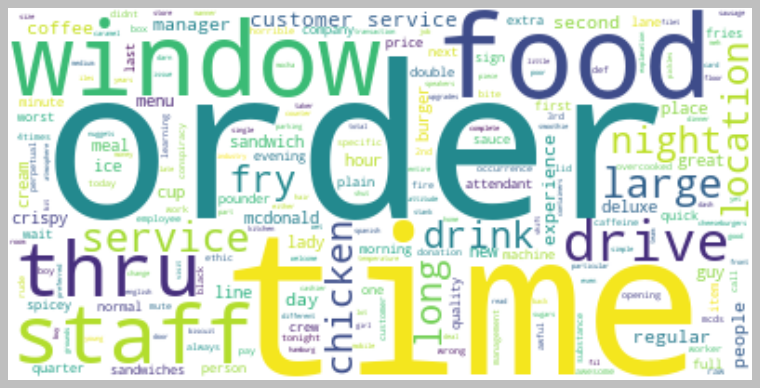

In [700]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
for aspect in all_aspects:
    text = text + " " + aspect
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [701]:
asd

NameError: name 'asd' is not defined

In [ ]:
# Preprocessing text
def preprocessing(text):
    text = remove_extra_spaces(text)
    text = expand_contractions(text)
    text = remove_non_ascii(text)
    return text



In [ ]:
def get_raw_abilities(doc):
    storage = {}
    first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']

    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    # Get mapper pronoun and antecedents
    mapper_pron_ant = get_mapper_pron_ant(doc)
        
    for idx, token in enumerate(doc):
        subjects = []
        abilities = []
    
        # If the token is verb
        if token.pos_ == 'VERB':
            
            for t in token.children:
                # Check if the token children contain subject.
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is first person pronoun
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

            if len(subjects) > 0:
                # Make sure the subject is unique
                subjects = list(set(subjects))
                
                # Store the result
                result = cross_product_tuple(subjects, token.lemma_)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
    
    
        # If the token is aux
        elif token.pos_ == 'AUX':
            
            # Looping through children
            for t in token.children:
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is pronoun I, me, my
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                        
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

                # Check if the neglect exist and depend on token aux
                neg = get_neglect(token)
                if t.dep_ == 'acomp':
                    # If neglection does not exist after aux, then check if it exist at first adj/verb
                    if not neg:
                        neg = get_neglect(t)
                    abilities.append(t.lemma_)
                    # Looping through the children of subject
                    # If neglection does not appear in after aux or before first subject.
                    #  Then check all neglection in first conjugation.
                    if not neg:
                        abilities += extract_conj(t, neglect=True, lemma=True)
                    else:
                        abilities += extract_conj(t, lemma=True)
                        abilities = cross_product_str(neg, abilities)
    
            if len(subjects) > 0 and len(abilities) > 0 :
                # Make sure the subject is unique
                subjects = list(set(subjects))

                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
            
        # If the token is noun
        elif token.pos_ == 'NOUN':
            # If only contains special characters or numbers, or length text less than 3
            if re.match(r'^[0-9\W]+$', token.text) or len(token.text) < 3:
                continue
            for t in token.lefts:
                if t.pos_ == 'ADJ':
                    neg = get_neglect(t)
                    if neg:
                        abilities.append(neg + ' ' + t.lemma_)
                    else:
                        abilities.append(t.lemma_)
    
            # If the token contain abilities, then we check is there any conjugation
            if len(abilities) > 0:
                subjects.append(token.lemma_)
                subjects += extract_conj(token, lemma=True)
                # Make sure the subject is unique
                subjects = list(set(subjects))


                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result

    return storage

In [ ]:
# import spacy

# # Load the spaCy model
# nlp = spacy.load("en_core_web_sm")

def extract_ability_property(doc):
    # doc = nlp(text)
    results = []
    
    for token in doc:
        # Check for noun/pronoun subjects
        if token.dep_ in ("nsubj", "nsubjpass"):
            subject = token.text
            
            # Check for verb indicating ability (auxiliary + ROOT)
            if token.head.pos_ == "VERB" and any(child.dep_ == "aux" for child in token.head.children):
                verb = token.head.text
                results.append((subject, f"can {verb}"))
            
            # Check for adjectives or adverbs indicating property
            for child in token.head.children:
                if child.dep_ in ("acomp", "advmod"):
                    property_ = child.text
                    results.append((subject, property_))
        
        # Check for noun/pronoun objects
        if token.dep_ == "dobj":
            obj = token.text
            
            # Check if object has any descriptive adjectives
            for child in token.children:
                if child.dep_ == "amod":  # adjectival modifier
                    property_ = child.text
                    results.append((obj, property_))
    
        # Check for relative clauses, nominal modifiers, and prepositional phrases
        for child in token.head.children:
            if child.dep_ == "relcl" or child.dep_ == "acl":
                property_ = child.text
                results.append((token.text, property_))
                
    return results

In [ ]:
# Test sentences
sentence1 = "The dog can run fast."
sentence2 = "The chef cooked a delicious meal."

docex = nlp(sentence1)
displacy.render(docex, 'dep')
print("Algorithm 1: ", get_raw_abilities(docex))
print("Algorithm 2: ", extract_ability_property(docex))  # Output: [('dog', 'can run'), ('dog', 'fast')]

docex = nlp(sentence2)
displacy.render(docex, 'dep')
print("Algorithm 1: ", get_raw_abilities(docex))
print("Algorithm 2: ", extract_ability_property(docex))  # Output: [('chef', 'cooked'), ('meal', 'delicious')]

In [ ]:
sentences = [
    "The cat can jump.",
    "The phone has a camera.",
    "Water can freeze.",
    "This car is fast.",
    "The sun gives light.",
    "The dog has sharp teeth.",
    "The computer can store data.",
    "My bike is lightweight.",
    "The wind can blow hard.",
    "Glass can break easily.",
    "The plant grows quickly.",
    "This material is waterproof.",
    "Birds can fly long distances.",
    "The phone charges wirelessly.",
    "This app automatically tracks your steps.",
    "The engine runs efficiently in cold weather.",
    "His voice carries across the room.",
    "Some animals can camouflage themselves.",
    "The robot is capable of learning new tasks.",
    "The building withstands strong earthquakes.",
    "This software adapts to user behavior over time.",
    "The bridge supports heavy loads without bending.",
    "The new processor processes data faster than previous models.",
    "These shoes reduce the impact on joints while running.",
    "The satellite transmits signals across continents.",
    "The medicine has anti-inflammatory properties.",
    "Solar panels convert sunlight into electricity efficiently.",
    "The AI system can predict stock market trends accurately.",
    "The genetic algorithm optimizes solutions for complex problems.",
    "The spacecraft is designed to sustain life for extended missions."
]


for s in sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print("Algorithm 1: ", get_raw_abilities(docex))
    print("Algorithm 2: ", extract_ability_property(docex))
    print("\n\n\n")

In [ ]:
neglected_sentences = [
    "The cat cannot jump.",
    "The phone doesn't have a camera.",
    "Water cannot freeze.",
    "This car is not fast.",
    "The sun doesn't give light.",
    "The dog doesn't have sharp teeth.",
    "The computer cannot store data.",
    "My bike is not lightweight.",
    "The wind cannot blow hard.",
    "Glass cannot break easily.",
    "The plant doesn't grow quickly.",
    "This material is not waterproof.",
    "Birds cannot fly long distances.",
    "The phone doesn't charge wirelessly.",
    "This app doesn't automatically track your steps.",
    "The engine doesn't run efficiently in cold weather.",
    "His voice doesn't carry across the room.",
    "Some animals cannot camouflage themselves.",
    "The robot is not capable of learning new tasks.",
    "The building doesn't withstand strong earthquakes.",
    "This software doesn't adapt to user behavior over time.",
    "The bridge doesn't support heavy loads without bending.",
    "The new processor doesn't process data faster than previous models.",
    "These shoes don't reduce the impact on joints while running.",
    "The satellite doesn't transmit signals across continents.",
    "The medicine doesn't have anti-inflammatory properties.",
    "Solar panels don't convert sunlight into electricity efficiently.",
    "The AI system cannot predict stock market trends accurately.",
    "The genetic algorithm doesn't optimize solutions for complex problems.",
    "The spacecraft is not designed to sustain life for extended missions."
]

for s in neglected_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print("Algorithm 1: ", get_raw_abilities(docex))
    print("Algorithm 2: ", extract_ability_property(docex))
    print("\n\n\n")

In [ ]:
passive_sentences = [
    "The door is opened easily.",
    "The car is driven by many people.",
    "The package was delivered yesterday.",
    "The glass can be broken with a hammer.",
    "The lights are turned on automatically.",
    "The cake is baked in the oven.",
    "The window was cleaned this morning.",
    "The table is made of wood.",
    "The music is played softly.",
    "The email was sent last night.",
    "The car was repaired quickly.",
    "The movie was watched by millions.",
    "The test is graded electronically.",
    "The flowers are grown in a greenhouse.",
    "The room was decorated for the party.",
    "The document is stored in the cloud.",
    "The road was blocked by traffic.",
    "The password is encrypted for security.",
    "The project was completed ahead of schedule.",
    "The bridge is constructed to withstand earthquakes.",
    "The machine is programmed to operate autonomously.",
    "The software was updated to include new features.",
    "The building is powered by solar energy.",
    "The message was translated into several languages.",
    "The painting is admired by art enthusiasts.",
    "The data is analyzed by artificial intelligence.",
    "The system was designed to improve efficiency.",
    "The book was inspired by historical events.",
    "The device is charged wirelessly overnight.",
    "The spacecraft is equipped to explore distant planets."
]


for s in passive_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print("Algorithm 1: ", get_raw_abilities(docex))
    print("Algorithm 2: ", extract_ability_property(docex))
    print("\n\n\n")

In [ ]:
negated_passive_sentences = [
    "The door is not opened easily.",
    "The car is not driven by many people.",
    "The package was not delivered yesterday.",
    "The glass cannot be broken with a hammer.",
    "The lights are not turned on automatically.",
    "The cake is not baked in the oven.",
    "The window was not cleaned this morning.",
    "The table is not made of wood.",
    "The music is not played softly.",
    "The email was not sent last night.",
    "The car was not repaired quickly.",
    "The movie was not watched by millions.",
    "The test is not graded electronically.",
    "The flowers are not grown in a greenhouse.",
    "The room was not decorated for the party.",
    "The document is not stored in the cloud.",
    "The road was not blocked by traffic.",
    "The password is not encrypted for security.",
    "The project was not completed ahead of schedule.",
    "The bridge is not constructed to withstand earthquakes.",
    "The machine is not programmed to operate autonomously.",
    "The software was not updated to include new features.",
    "The building is not powered by solar energy.",
    "The message was not translated into several languages.",
    "The painting is not admired by art enthusiasts.",
    "The data is not analyzed by artificial intelligence.",
    "The system was not designed to improve efficiency.",
    "The book was not inspired by historical events.",
    "The device is not charged wirelessly overnight.",
    "The spacecraft is not equipped to explore distant planets."
]

for s in negated_passive_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print("Algorithm 1: ", get_raw_abilities(docex))
    print("Algorithm 2: ", extract_ability_property(docex))
    print("\n\n\n")

In [ ]:
# sample = 'The door is opened easily and not quickly.'
# sample = 'The glass cannot be broken with a hammer, knife, and sword.'
# sample = 'The machine is programmed to operate autonomously and not fastly'
sample = 'The bridge is constructed to withstand earthquakes and flames'
doc = nlp(sample)

def get_raw_abilities_passive(doc):
    result = []
c                
            # If at least one ability is extracted
            if len(abilities) > 0:
                # Store to the result storage
                result += cross_product_tuple(token.text, abilities)
    return result
    

get_raw_abilities_passive(doc)

In [ ]:
# doc = nlp('The machine is programmed to operate autonomously and fastly')
displacy.render(doc, 'dep')

In [ ]:
for s in passive_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print("Algorithm 1: ", get_raw_abilities(docex))
    print("Algorithm 2: ", extract_ability_property(docex))
    print("Algorithm 3: ", get_raw_abilities_passive(docex))
    print("\n\n\n")

In [ ]:
for s in negated_passive_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print("Algorithm 1: ", get_raw_abilities(docex))
    print("Algorithm 2: ", extract_ability_property(docex))
    print("Algorithm 3: ", get_raw_abilities_passive(docex))
    print("\n\n\n")

In [ ]:
# (DONE) 1. If nsubjpass ==> Go to Head (verb) ==> In head children, get auxpass ==> Go to adverb after verb (advmod)
#    ==> Subject passive + auxpass + Verb + advmod
#    E.g: The door is opened easily ==> (Door, is opened easily)

# (DONE) 2. If nsubjpass ==> Go to Head (verb) ==> In head children, get auxpass ==> Go to adposition (ADP tag or agent dependency) ==> Get pobj
#    ==> Subject passive + auxpass + Verb + agent + Preposition object
#    E.g: The car is driven by many people ==> (Car, is driven by people)

# (DONE) 3. If nsubjpass ==> Go to Head (verb) ==> In head children, get auxpass ==> Subject passive + auxpass + Verb
#    E.g: The package was delivered yesterday ==> (Package, was delivered)

# (DONE) 4. If nsubjpass ==> Go to Head (verb) ==> In head children, get auxpass ==> If head children contain aux, append it ==> Go to preposition phrase
#    (ADP pos tag or prep dependency) ==> Get pobj ==> Subject passive + aux + auxpass + Preposition phrase + Preposition object
#    E.g: The glass can be broken with a hammer ==> (Glass, can be broken with hammer)

# (DONE) 5. If nsubjpass ==> Go to Head (verb) ==> In head children, get auxpass ==> Go to adverb after verb (advmod) ==> If contain preposition phrase
#    ==> Subject passive + auxpass + Verb + advmod + Preposition phrase + Preposition object
#    E.g: The project was completed ahead of schedule ==> (Project, was completed ahead of schedule)

# (DONE) 6. If nsubjpass ==> Go to Head (verb) ==> In head children, get auxpass ==> Go to xcomp, get the xcomp ==> Go to direct object.
#    ==> Subject passive + auxpass + Verb + xcomp + Direct object
#    E.g: The bridge is constructed to withstand earthquakes ==> (Bridge, is constructed withstand earthquakes)

# (DONE) 7. If nsubjpass ==> Go to Head (verb) ==> In head children, get auxpass ==> Go to xcomp, get the xcomp ==> Go to advmod.
#    ==> Subject passive + auxpass + Verb + xcomp + advmod
#    E.g: The machine is programmed to operate autonomously. ==> (Machine, is programmed operate autonomously)

# (DONE) 8. If nsubjpass ==> Go to Head (verb) ==> In head children, get auxpass ==> Go to adverb after verb (advmod) ==> Get all adverb (or advmod) before
#    current advmod.
#    ==> Subject passive + auxpass + Verb + advmod + advmod
#    E.g: The device is charged wirelessly overnight ==> (Device, is charged wirelessly overnight)


# NOTE:- For subject/object, try to: (1) multiple subject/object (DONE), (2) Neglection (DONE), (3) (DONE) Adjective pre-modifier object. 
#         (4) (DONE) Adverb pre-modifier another adverb. (5) (DONE) Get the aux from xcomp token.
#      - In case xcomp exist in sentence, the property of subject is xcomp + advmod/obj.

In [ ]:
def crawling_after_token_prep_phrase(token, neglect=False):
    result = []
    basis_idx = token.i
    prep = get_all_token_dep(token, dep='prep')
    if prep:
        # If contain children: dep pcomp dep VERB pos tag; Until reach dobj or pobj
        for p in prep:
            prep_idx = p.i
            # If the preposition on the left basis token index, continue
            if basis_idx > prep_idx:
                continue
                
            current = get_token_dep(p, dep=['pcomp', 'dobj', 'pobj'])
            # Store objects
            obj = []
            # Store complement
            comp = [p.text]
            while current:
                text = current.text
                # If current token is object, get the pre-modifier adjective
                if current.dep_ in ['dobj', 'pobj']:
                    pre_adj = ' '.join(extract_pre_adj(current))
                    obj += cross_product_str(pre_adj, text)

                    # Extract conjunct object
                    obj_conj = extract_conj(current, neglect=neglect)
                    if len(obj_conj) > 0:
                        obj += obj_conj
                else:
                    comp = cross_product_str(comp, text)
                    
                current = get_token_dep(current, dep=['pcomp', 'dobj', 'pobj'])

            # temp = sorted(temp, key=lambda x: x[1])
            # temp = " ".join([t[0] for t in temp])

            # result.append(temp)
            result += cross_product_str(comp, obj)
            
    return result

# def extract_pre_adj(token, lemma=False):
#     result = []
#     current_idx = token.i
#     for child in token.children:
#         if child.pos_ == 'ADJ' and child.i < current_idx:
#             if lemma:
#                 result.append((child.lemma_, child.i))
#             else:
#                 result.append((child.text, child.i))

#     # Sort by its index
#     result = sorted(result, key=lambda x: x[1])

#     # Return only list of string
#     result = [item[0] for item in result]

#     return result

In [ ]:
# storage = {}
# first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']

# # Get sentence mapper and prepare storage
# sentence_points = {}
# for i, s in enumerate(doc.sents):
#     sentence_points[i] = (s.start, s.end)
#     storage[i] = []

# # Get mapper pronoun and antecedents
# mapper_pron_ant = get_mapper_pron_ant(doc)

import pandas as pd
data_verb = pd.read_csv('verb_transitivity.tsv', sep='\t')

map_verb_intrans = data_verb[['verb', 'percent_intrans']].set_index('verb').to_dict()['percent_intrans']


# sample = "This software adapts to user behavior over time."
# sample = "The engine runs efficiently in cold weather"
# sample = "His voice carries across the room"
# sample = "Glass can break easily"
# sample = "The sun gives light" 
# sample = "The robot is capable of learning new tasks."
# sample = "She quickly ran gracefully through the forest."

# Case root is aux
# sample = "They are all friendly, accommodating and always smiling"
# Case root is verb
# sample = "They are accommodating, friendly, and never smiling"
sample = "The robot is capable of learning new tasks."

doc = nlp(sample)

def get_raw_abilities_new(doc):
    # Define local variable.
    storage = {}
    first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']

    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    # Get mapper pronoun and antecedents
    mapper_pron_ant = get_mapper_pron_ant(doc)

    # Define local variable.
    result = []
    for idx, token in enumerate(doc):
        abilities = []

        # Initial filter: If token only contains special characters or numbers, or length text less than 3
        if (re.match(r'^[0-9\W]+$', token.text)) or (len(token.text) < 3):
            continue

        ## ==================== SUBJECT ACTIVE SENTENCE =========================== ##
        # If token is subject (should be nsubj and nsubjpass). This time only nsubj
        # In case active sentence form
        if token.dep_ == 'nsubj':
            # Go to its head
            head = token.head

            # Get neglect; If there is no neglect, return empty text.
            neg = get_neglect(head)

            # If head is Verb.
            if head.pos_ == 'VERB':

                # Get all conjunct (except adjective with dependency acomp)
                if neg:
                    verb_conjunct = extract_conj(head)
                else:
                    # If neglect do not come at first, then check neglection in front each conjunct.
                    verb_conjunct = extract_conj(head, neglect=True)
                
                # Rule 2 and 5: If the verb is posession
                if head.lemma_ == 'have':
                    
                    # Get direct object
                    obj = get_token_dep(head, dep='dobj')
                    
                    # If direct object exist
                    if obj:
                        # Extract all possible pre-modifier adjectives
                        pre_adj_text = ' '.join(extract_pre_adj(obj))
                        
                        # Concatenate components into: Adj (optional) + Direct object
                        ability = cross_product_str(pre_adj_text, obj.text)
                        # Concatenate components into: Verb (Have) + Adj (optional) + Direct object
                        ability = cross_product_str(head.lemma_, ability)
                        # Concatenate components into: not (optional) + Verb (Have) + Adj (optional) + Direct object
                        ability = cross_product_str(neg, ability)
                        
                        # Add the ability into abilities
                        abilities = abilities + ability
                        # EXPECTED PATTERN: Subject + not (optional) + Verb (Have) + Adj (optional) + Direct object

                        # If the object has conjunct
                        obj_conjunct = extract_conj(obj)
                        if len(obj_conjunct) > 0:
                            # Concatenate components into: Verb (Have) + Conjunct
                            ability = cross_product_str(head.lemma_, obj_conjunct)
                            # Concatenate components into: not (optional) + Verb (Have) + Conjunct
                            ability = cross_product_str(neg, ability)
                            
                            # Add the ability into abilities
                            abilities = abilities + ability
                            # EXPECTED PATTERN: Subject + not (optional) + Verb (Have) + Direct object
                            # Note: Since normaly, If direct object is noun/propn/pron the conjuncts are noun/propn/pron too.
                            #        This rule follow this concept. In somehow, the conjunct could be adjective or another verb.

                    # If the verb is posession but do not have direct object (object that the subject posessed) continue
                    else:
                        continue
                else:
                    # Get aux
                    aux = get_token_dep(head, dep='aux')
        
                    # Get Pre and post adv
                    pre_adv, post_adv = extract_adv(head)
                    # Convert pre and post adverb into string
                    pre_adv = (' '.join(pre_adv)).strip()
                    post_adv = (' '.join(post_adv)).strip()
        
                    # Get Preposition after verb
                    prep_after_verb = crawling_after_token_prep_phrase(head)
                    
                    # Get intransitive rate score
                    int_rate = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
                    # If the verb is not in the mapper ( we assume it is transitive verb )
                    if not int_rate:
                        int_rate = 0

                    # Concatenate components into: adv (optional) + verb
                    ability = cross_product_str(pre_adv, head.text)
                    # Concatenate components into: not (optional) + adv (optional) + verb
                    ability = cross_product_str(neg, ability)
                    # Concatenate components into: not (optional) + adv (optional) + verb + adv (optional)
                    ability = cross_product_str(ability, post_adv)
                        
                    # If aux exist, add the text into ability_text
                    if aux:
                        # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adv (optional)
                        ability = cross_product_str(aux.text, ability)                    
                    
                    # If the verb is intransitive or Adverb after verb exist
                    if (int_rate >= 0.5) or (post_adv):
                        # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + adv
                        abilities = abilities + ability

                    # If the verb is transitive
                    else:                          
                        # Get the direct object
                        obj = get_token_dep(head, dep='dobj')
                        # If the direct object exist
                        if obj:                            
                            # Get pre adjective modifier direct object and convert in into string
                            pre_adj = ' '.join(extract_pre_adj(obj))
                            # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adj (optional)
                            ability = cross_product_str(ability, pre_adj)
                            # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adj (optional) + Direct object
                            ability = cross_product_str(ability, obj.text)

                            # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + adj (optional) + Direct object
                            abilities = abilities + ability

                    # If the preposition phrase exists after verb
                    if prep_after_verb:
                        # Concatenate components into: adv (optional) + verb
                        ability = cross_product_str(pre_adv, head.text)
                        # Concatenate components into: not (optional) + adv (optional) + verb
                        ability = cross_product_str(neg, ability)
                        # If auxiliary token exist
                        if aux:
                            # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb
                            ability = cross_product_str(aux.text, ability)
                            
                        # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + preposition phrase
                        ability = cross_product_str(ability, prep_after_verb)

                        # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + preposition phrase
                        abilities = abilities + ability

                    if len(verb_conjunct) > 0:
                        # Extract ability
                        ability = cross_product_str(neg, verb_conjunct)
                        if aux:
                            ability = cross_product_str(aux.text, ability)
                        abilities = abilities + ability
    
            # Rule 2 and 10
            elif head.pos_ == 'AUX':
                # Get the token
                # NOTE: if 'AUX' is root, only have one adjective with dependency acomp.
                adj_token = get_token_dep(head, dep='acomp')
                
                # Get Preposition after adjective
                prep_after_adj = ' '.join(crawling_after_token_prep_phrase(adj_token))

                # Concatenate components into: aux + not (optional)
                ability = cross_product_str(head.text, neg)
                # Concatenate components into: aux + not (optional) + adj
                ability = cross_product_str(ability, adj_token.text)
                # Concatenate components into: aux + not (optional) + adj + preposition phrase (optional)
                ability = cross_product_str(ability, prep_after_adj)

                # EXPECTED PATTERN: Subject + aux + not (optional) + adj
                abilities = abilities + ability

                # Get all conjunct (except adjective with dependency acomp)
                if neg:
                    adj_conjunct = extract_conj(adj_token)
                else:
                    # If neglect do not come at first, then check neglection in front each conjunct.
                    adj_conjunct = extract_conj(adj_token, neglect=True)
                    
                if len(adj_conjunct) > 0:
                    # Concatenate components into: aux + not (optional)
                    ability = cross_product_str(head.text, neg)
                    # Concatenate components into: aux + not (optional) + adj
                    ability = cross_product_str(ability, adj_conjunct)
                    # EXPECTED PATTERN: Subject + aux + not (optional) + adj
                    abilities = abilities + ability

        ## ==================== SUBJECT PASSIVE SENTENCE =========================== ##
        # If sentence is passive form.
        if token.dep_ == 'nsubjpass':
            # Get the token head (verb). Since passive form at least form: Subject + auxpass + verb 
            head = token.head

            ##================= GET ALL POSSIBLE COMPONENTS ===============##
            # Get neglect; If there is no neglect, return empty text.
            neg = get_neglect(head)
    
            # Get auxpass token
            auxpass = get_token_dep(head, dep='auxpass')
    
            # Get aux token
            aux = get_token_dep(head, dep='aux')
            
            # Get advmod after verb token
            advmod_main = get_token_dep_right(head, dep=['advmod', 'npadvmod'])
            if advmod_main:
                pre_advmod_main, post_advmod_main = extract_adv(advmod_main)
                pre_advmod_main = ' '.join(pre_advmod_main)
                post_advmod_main = ' '.join(post_advmod_main)
    
            # Get the agent token
            agent = get_token_dep_right(head, dep='agent')
            obj_agent = None
            # If the agent token exist
            if agent:
                # Get the object that refers to 'agent' token
                obj_agent = get_token_dep(agent, dep=['pobj', 'dobj'])
    
            # Get prepositional phrase
            if neg:
                prep_after_verb = crawling_after_token_prep_phrase(head)
            else:
                prep_after_verb = crawling_after_token_prep_phrase(head, neglect=True)
    
            # Get xcomp token
            xcomp = get_token_dep(head, dep='xcomp')
            # Initalize object and advmod of xcomp.
            obj_xcomp = None
            advmod_xcomp = None
            if xcomp:
                # Get the aux, adv, and obj of xcomp tokens.
                aux_xcomp = get_token_dep(xcomp, dep='aux')
                obj_xcomp = get_token_dep(xcomp, dep=['pobj', 'dobj'])
                advmod_xcomp = get_token_dep_right(xcomp, dep='advmod')
                # If adv modifier of xcomp exist
                if advmod_xcomp:
                    # Get pre and post adverb of main adverb modifier xcomp.
                    pre_advmod_xcomp, post_advmod_xcomp = extract_adv(advmod_xcomp)
                    pre_advmod_xcomp = ' '.join(pre_advmod_xcomp)
                    post_advmod_xcomp = ' '.join(post_advmod_xcomp)

            ##================= STORING ABILITIES ===============##                
            # Store ability: If adverb modifier exist
            if advmod_main:
                # If aux exist
                if aux:
                    # Concatenate components: aux (optional) + neg (optional)
                    ability = cross_product_str(aux.text, neg)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass
                    ability = cross_product_str(ability, auxpass.text)
                else:
                    # Concatenate components: auxpass + neg (optional)
                    ability = cross_product_str(auxpass.text, neg)

                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                ability = cross_product_str(ability, head.text)
                
                # If pre adverb exist
                if pre_advmod_main:
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional)
                    ability = cross_product_str(ability, pre_advmod_main)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional) + advmod
                ability = cross_product_str(ability, advmod_main.text)
    
                # Get prepositional phrase after adverb
                prep_after_adv = crawling_after_token_prep_phrase(advmod_main)
                if prep_after_adv:
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional)
                    #                            + advmod + preposition phrase (optional)
                    ability = cross_product_str(ability, prep_after_adv)

                # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional)
                #                      + advmod + preposition phrase (optional)
                abilities += ability

                # Get all the adverb conjuncts
                # If neglection exist
                if neg:
                    # It assume that all conjuncts are neglection 
                    advmod_main_conj = extract_conj(advmod_main)
                else:
                    # If neglect do not come at first, then check neglection in front each conjunct
                    advmod_main_conj = extract_conj(advmod_main, neglect=True)

                # If adverb has conjunct                
                if len(advmod_main_conj) > 0:
                    # If contain aux
                    if aux:
                        # Concatenate components: aux (optional) + neg (optional)
                        ability = cross_product_str(aux.text, neg)
                        # Concatenate components: aux (optional) + neg (optional) + auxpass
                        ability = cross_product_str(ability, auxpass.text)
                    else:
                        # Concatenate components: auxpass + neg (optional)
                        ability = cross_product_str(auxpass.text, neg)

                    # Concatenate components: aux (optional) + neg (optional) + auxpass
                    ability = cross_product_str(ability, head.text)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + advmod
                    ability = cross_product_str(ability, advmod_main_conj)
                    # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass
                    abilities = abilities + ability

            # Store ability: If agent and object agent token exist
            if obj_agent and agent:
                # If aux exist
                if aux:
                    # Concatenate components: aux (optional) + neg (optional)
                    ability = cross_product_str(aux.text, neg)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass
                    ability = cross_product_str(ability, auxpass.text)
                else:
                    # Concatenate components: auxpass + neg (optional)
                    ability = cross_product_str(auxpass.text, neg)

                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb 
                ability = cross_product_str(ability, head.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + agent
                ability = cross_product_str(ability, agent.text)
                
                # Get the pre adjective of object
                pre_adj = ' '.join(extract_pre_adj(obj_agent))
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + agent + adj (optional)
                ability = cross_product_str(ability, pre_adj)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + agent + adj (optional) + object
                ability = cross_product_str(ability, obj_agent.text)
                # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + agent + adj (optional) + object
                abilities += ability

                # Get all object conjuncts
                if neg:
                    obj_agent_conj = extract_conj(obj_agent)
                else:
                    # If neglect do not come at first, then check neglection in front each conjunct.
                    obj_agent_conj = extract_conj(obj_agent, neglection=True)
                # If object conjuncts exist
                if len(obj_agent_conj) > 0:
                    # If aux exist
                    if aux:
                        # Concatenate components: aux (optional) + neg (optional)
                        ability = cross_product_str(aux.text, neg)
                        # Concatenate components: aux (optional) + neg (optional) + auxpass
                        ability = cross_product_str(ability, auxpass.text)
                    else:
                        # Concatenate components: auxpass + neg (optional)
                        ability = cross_product_str(auxpass.text, neg)

                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                    ability = cross_product_str(ability, head.text)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + object
                    ability = cross_product_str(ability, obj_agent_conj)
                    # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + object
                    abilities = abilities + ability
    
            # Store ability: If preposition after verb exist
            if prep_after_verb:
                # If aux exist
                if aux:
                    # Concatenate components: aux (optional) + neg (optional)
                    ability = cross_product_str(aux.text, neg)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass
                    ability = cross_product_str(ability, auxpass.text)
                else:
                    # Concatenate components: auxpass + neg (optional)
                    ability = cross_product_str(auxpass.text, neg)

                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                ability = cross_product_str(ability, head.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + preposition phrase
                ability = cross_product_str(ability, prep_after_verb)

                # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + preposition phrase
                abilities += ability
    
            # Store ability: If xcomp and object xcomp exist
            if obj_xcomp and xcomp:
                # If aux exist
                if aux:
                    # Concatenate components: aux (optional) + neg (optional)
                    ability = cross_product_str(aux.text, neg)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass
                    ability = cross_product_str(ability, auxpass.text)
                else:
                    # Concatenate components: auxpass + neg (optional)
                    ability = cross_product_str(auxpass.text, neg)
                    
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                ability = cross_product_str(ability, head.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp
                ability = cross_product_str(ability, aux_xcomp.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp
                ability = cross_product_str(ability, xcomp.text)
                
                # Get the pre adjective of object
                pre_adj = ' '.join(extract_pre_adj(obj_xcomp))
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + adj (optional)
                ability = cross_product_str(ability, pre_adj)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + adj (optional) + object
                ability = cross_product_str(ability, obj_xcomp.text)
                # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + adj (optional) + object
                abilities += ability
                
                # Get all object conjuncts
                if neg:
                    obj_xcomp_conj = extract_conj(obj_xcomp)
                else:
                    # If neglect do not come at first, then check neglection in front each conjunct.
                    obj_xcomp_conj = extract_conj(obj_xcomp, neglect=True)
                # If object conjuncts exist
                if len(obj_xcomp_conj) > 0:
                    # If aux exist
                    if aux:
                        # Concatenate components: aux (optional) + neg (optional)
                        ability = cross_product_str(aux.text, neg)
                        # Concatenate components: aux (optional) + neg (optional) + auxpass
                        ability = cross_product_str(ability, auxpass.text)
                    else:
                        # Concatenate components: auxpass + neg (optional)
                        ability = cross_product_str(auxpass.text, neg)

                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                    ability = cross_product_str(ability, head.text)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp
                    ability = cross_product_str(ability, aux_xcomp.text)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp
                    ability = cross_product_str(ability, xcomp.text)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + object
                    ability = cross_product_str(ability, obj_xcomp_conj)
                    # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + object
                    abilities = abilities + ability

            # Store ability: If xcomp and object xcomp exist
            if advmod_xcomp and xcomp:
                # If aux exist
                if aux:
                    # Concatenate components: aux (optional) + neg (optional)
                    ability = cross_product_str(aux.text, neg)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass
                    ability = cross_product_str(ability, auxpass.text)
                else:
                    # Concatenate components: auxpass + neg (optional)
                    ability = cross_product_str(auxpass.text, neg)
                    
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                ability = cross_product_str(ability, head.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp
                ability = cross_product_str(ability, aux_xcomp.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp
                ability = cross_product_str(ability, xcomp.text)
                # If pre advmod xcomp exist
                if pre_advmod_xcomp:
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp + pre-advmod (optional)
                    ability = cross_product_str(ability, pre_advmod_xcomp)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp + pre-advmod (optional) + advmod
                ability = cross_product_str(ability, advmod_xcomp.text)
                # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp + pre-advmod (optional) + advmod
                abilities += ability  

                # Get all advmod conjuncts
                if neg:
                    advmod_xcomp_conj = extract_conj(advmod_xcomp)
                else:
                    # If neglect do not come at first, then check neglection in front each conjunct.
                    advmod_xcomp_conj = extract_conj(advmod_xcomp, neglect=True)
                # If advmod conjuncts exist
                if len(advmod_xcomp_conj) > 0:
                    if aux:
                        # Concatenate components: aux (optional) + neg (optional)
                        ability = cross_product_str(aux.text, neg)
                        # Concatenate components: aux (optional) + neg (optional) + auxpass
                        ability = cross_product_str(ability, auxpass.text)
                    else:
                        # Concatenate components: auxpass + neg (optional)
                        ability = cross_product_str(auxpass.text, neg)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                    ability = cross_product_str(ability, head.text)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp
                    ability = cross_product_str(ability, aux_xcomp.text)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp
                    ability = cross_product_str(ability, xcomp.text)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + advmod
                    ability = cross_product_str(ability, advmod_xcomp_conj)
                    # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + advmod
                    abilities += ability
                
        # Store final result
        if len(abilities) > 0:
            # Subject handling
            text = token.lemma_
            # current_idx = token.i
            # If the subject is pronouns and first person pronouns
            if token.pos_ == 'PRON' and token.text.lower() in first_person_pronouns:
                subject = 'the user'
            # If subject is pronouns and its token location in mapper_pron_ant
            elif token.pos_ == 'PRON' and idx in mapper_pron_ant.keys():
                # Get the antecedent index location
                idx_map = mapper_pron_ant[idx]
                # Change current token subject
                token = doc[idx_map]
                text = token.lemma_
            # If the current child is pronoun (but not in mapper_pron_ant keys)
            elif token.pos_ == 'PRON':
                continue
            
            # Get all conj subject + current subject
            subjects = [token.text] + extract_conj(token)
            # Store result
            result += cross_product_tuple(subjects, abilities)
            # Storage final result
            sentence_location = get_sentence_location(sentence_points, idx)
            storage[sentence_location] += result

    # Storing final result
    return storage

get_raw_abilities_new(doc)


# NOTE: 
# - This rule is not good enough for subject passive. (should update it)
# - This rule is not good enough for pronouns type subject. Fix it.
# - Try case conjunct of verb

In [ ]:
# doc = nlp('We have no information on whether users are at risk')
# doc = nlp('I am excited about the trip and that we will meet again.')
doc = nlp('This software adapts to user behavior over time.')
displacy.render(doc, 'dep')

In [ ]:
for s in sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print("Algorithm 1: ", get_raw_abilities(docex))
    print("Algorithm 2: ", extract_ability_property(docex))
    print("Algorithm 3: ", get_raw_abilities_new(docex))
    print("\n\n\n")

# FAIL:
# His voice carries across the room. (SOLVED)
# This software adapts to user behavior over time. (SOLVED)

In [ ]:
# Potential more than one: (1) (DONE) Prepositional phrase (2) (DONE) Subject (3) Object (4) (DONE) Ability ==> Verb + adv or Verb + Prep + object

In [ ]:
# (DONE) 1. If token is NOUN (or subject) ==> Go to verb ==> If the verb contain child as dep aux ==> SUBJECT + aux + Verb.
#      E.g: The cat can jump ==> (cat, can jump)

# (DONE) 2. If token is NOUN (or subject) ==> Go to verb (if the verb is 'have' or 'has'; better using lemma for generalizer past form)
#      ==> If the verb contain child as dep dobj ==> Subject + Has + dobj. 
#      E.g: The phone has a camera ==> (phone, has camera)

# (DONE) 3. If token is NOUN (or subject) ==> Go to aux (and verb do not exist); aux is head of subject ==> If the aux contain adj (or acomp) 
#      ==> Subject + aux + ADJ.
#      E.g: This car is fast ==> (car, is fast)

# (DONE) 4. If the token is NOUN (or subject) ==> Go to verb, if the verb is "transfer posession verb" or "keeping posession" or "verbs adapting behavior"
#      ==>  If the verb contain child as dep aux or dep dobj ==> Subject + aux (optional) + verb + dobj.
#      E.g: The sun gives light ==> (sun, gives light)
#           The computer can store data ==> (computer, can store data)

# (DONE) 5. If token is NOUN (or subject) ==> Go to verb (if the varb lemma is 'have' or 'has') ==> If the verb contain child as dep dobj
#     ==> If the dobj has pre-modifier (ADJ on the left; or dependency amod) ==> Subject + verb + pre-modifier + dobj
#     E.g: The dog has sharp teeth ==> (Dog, has sharp teeth)

# (DONE) 6. If token is NOUN (or subject) ==> Go to verb ==> If the verb contain child as dep aux ==> If the verb contain adverb or dep advmod on the right
#    (do not contain dobj) ==> Subject + aux + verb + adv
#    E.g: Glass can break easily ==> (Glass, can break easily) 

# (DONE) 7. If token is NOUN (or subject) ==> Go to verb ==> If the verb contain adverb or dep advmod on the left ==> If the verb contain obj
#    ==> Subject + adv + verb + dobj
#    E.g: This app automatically tracks your steps ==> (app, automatically tracks steps)

# (DONE) 8. If the token is NOUN (or subject) ==> Go to verb ==> If the verb children contains adv (dep advmod), append it ==> If the verb children contains
#    dep prep (or ADP pos tag) ==> If it contain preposition object ==> If contain adjective modifier. ==> Subject + Verb + Adv + Prep + Object
#    E.g: The engine runs efficiently in cold weather ==> [(Engine, runs efficiently), (Engine, runs in cold weather)]

# (DONE) 9. If the token is NOUN (or subject) ==> Go to verb ==> If the verb children contains dep prep (or ADP pos tag) ==> If it contain preposition object
#    ==> Subject + Verb + prep + object
#    E.g: His voice carries across the room ==> (voice, carries accross room)


# (DONE) 10. If token is NOUN (or subject) ==> Go to aux (and verb do not exist); aux is head of subject ==> If the aux contain adj (or dep acomp)
#      ==> If the adj contain prep ==> If the prep children contain verb (or dep pcomp) ==> If the pcomp children contain noun (or dobj)
#      ==> Subject + aux + ADJ + prep + pcomp + dobj
#      E.g: The robot is capable of learning new tasks. ==> (robot, is capable of learning tasks)


In [ ]:
trf_posession_verb = [
    "give",
    "donate",
    "hand",
    "deliver",
    "pass",
    "grant",
    "transfer",
    "transmit",
    "convey",
    "bestow",
    "lend",
    "offer",
    "present",
    "assign",
    "bequeath",
    "contribute",
    "yield",
    "endow",
    "lease",
    "sell",
    "trade",
    
]

verbs_keeping_possession = [
    "keep",
    "hold",
    "retain",
    "maintain",
    "store",
    "save",
    "withhold",
    "withstand",
    "preserve",
    "guard",
    "hoard",
    "reserve",
    "secure",
    "protect",
    "cling",
    "possess",
    "own",
    "control",
    "occupy",
    "safeguard",
    "grasp"
]


verbs_adapting_behavior = [
    "adapt",
    "adjust",
    "acclimate",
    "accommodate",
    "modify",
    "alter",
    "conform",
    "respond",
    "revise",
    "recalibrate",
    "reorient",
    "shift",
    "readjust",
    "realign",
    "reform",
    "innovate",
    "evolve",
    "transition",
    "improvise",
    "customize",
    "learning",
    "reduce",
    "support",
    "convert",
    "optimizie",
]

In [ ]:
docex = nlp("They have a discussion about the project")
displacy.render(docex, 'dep')

for token in docex:
    print(token.text, token.lemma_)

In [ ]:
import pandas as pd

data_verb = pd.read_csv('verb_transitivity.tsv', sep='\t')

map_verb_intrans = data_verb[['verb', 'percent_intrans']].set_index('verb').to_dict()['percent_intrans']

map_verb_intrans['optimize']